In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 -4*x + 5

In [3]:
f(3.0)

20.0

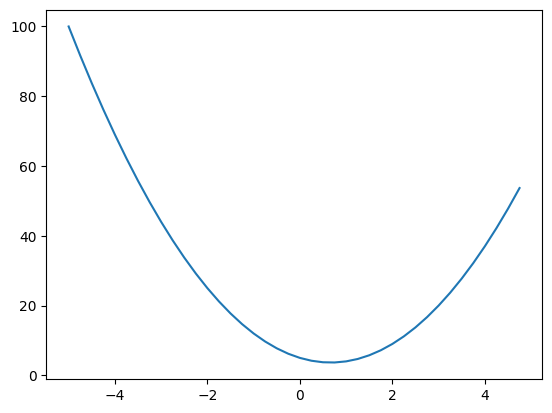

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h = 0.000001
x = 2/3
(f(x + h) - f(x)) / h

2.999378523327323e-06

In [6]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [7]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print ('slope', (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [8]:
class Value:
    def __init__(self, data, _children=(), _op = '', label=''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self._backward = lambda: None
    
    def __repr__(self):
        return f"Value (data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            
        out._backward = _backward    
        return out
  
    def __radd__(self, other): # other + self
        return self + other

    def __neg__(self):
        return self * -1
        
    def __sub__(self, other):
        return self + (- other)
        
    def __rsub__(self, other):
        return other + (-self) 

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward    
        return out

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other**-1

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
            
        out._backward = _backward    
        return out
        
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
 
        def _backward():
            self.grad += (1 - t**2) * out.grad
         
        out._backward = _backward    
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
 
        def _backward():
            self.grad += out.data * out.grad
         
        out._backward = _backward    
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
          if v not in visited:
            visited.add(v)
            for child in v._prev:
              build_topo(child)
            topo.append(v)
        build_topo(self)
        self.grad = 1.0

        for node in reversed(topo):
            node._backward()        


In [9]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

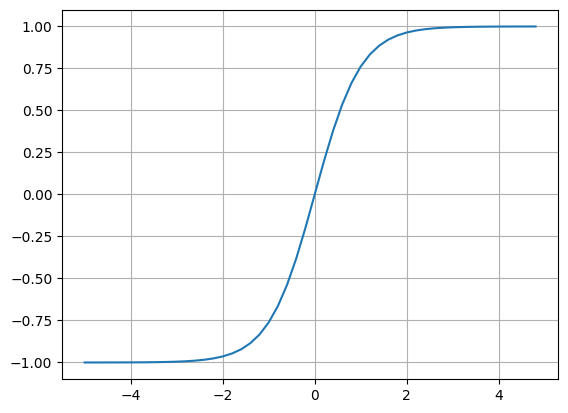

In [10]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid();

In [11]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

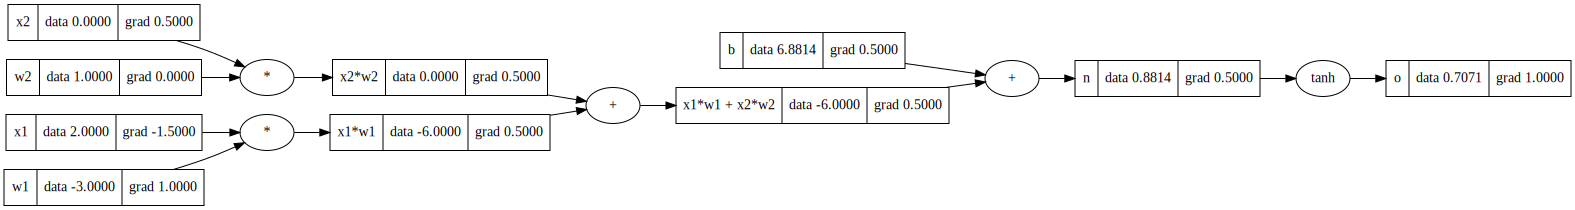

In [12]:
draw_dot(o)

In [13]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2 * n).exp(); e.label='e'
o = (e - 1) / (e + 1); o.label = 'o'
o.backward()

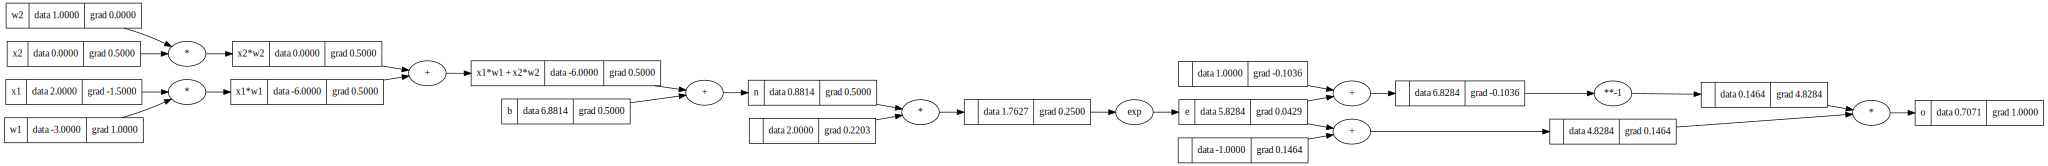

In [14]:
draw_dot(o)

In [15]:
o.backward()

In [16]:
n.grad = 1 - o.data**2

In [17]:
n.grad

0.4999999999999998

In [18]:
x1w1x2w2.grad = n.grad
b.grad = n.grad
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad
x1.grad = w1.data * x1w1.grad
x2.grad = w2.data * x2w2.grad
w1.grad = x1.data * x1w1.grad
w2.grad = x2.data * x2w2.grad

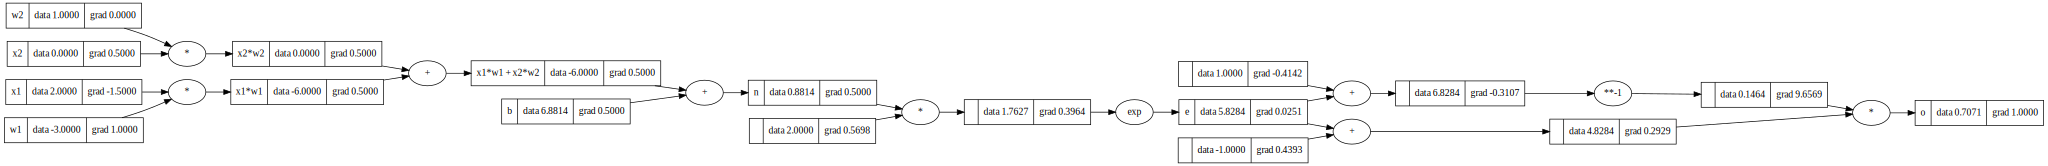

In [19]:
draw_dot(o)

In [20]:
o.grad = 1.0
o._backward()

In [21]:
n._backward()

In [22]:
x1w1x2w2._backward()

In [23]:
x1w1._backward()

In [24]:
x2w2._backward()

In [25]:
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

[Value (data=2),
 Value (data=1.0),
 Value (data=0.0),
 Value (data=0.0),
 Value (data=-3.0),
 Value (data=2.0),
 Value (data=-6.0),
 Value (data=-6.0),
 Value (data=6.881373587019543),
 Value (data=0.8813735870195432),
 Value (data=1.7627471740390863),
 Value (data=5.828427124746192),
 Value (data=1),
 Value (data=6.828427124746192),
 Value (data=0.1464466094067262),
 Value (data=-1),
 Value (data=4.828427124746192),
 Value (data=0.7071067811865477)]

In [26]:
o._grad = 1.0

for node in reversed(topo):
    node._backward()

In [27]:
o.backward()

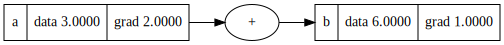

In [28]:
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

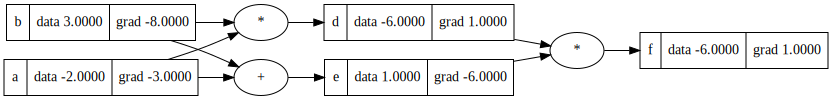

In [29]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

In [30]:
a = Value(2.0)
a * 1


Value (data=2.0)

In [31]:
2*a

Value (data=4.0)

In [32]:
b = Value(2.0)
a/b

Value (data=1.0)

In [33]:
a-b


Value (data=0.0)

In [34]:
import torch

In [35]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [36]:
o.item()

0.7071066904050358

In [37]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1)) 

    def __call__(self, x):
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]
    

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


The neuron below has 3 inputs. It also has 1 output. All neurons always have 1 output. Sometimes you see more outputs on diagrams, but this is because they send the same output to several neurons in the next layer.

![title](neuron.jpeg)

In [38]:
x = [2.0, 3.0, -1.0]
n = Neuron(3)
n(x)

Value (data=0.26484141439933945)

This is 3x4 layer. It means that every neuron in the input has 3 inputs, and there are 4 neurons in the layer, so there are 4 outputs. Note, that all input values are same for all input neurons at a time. So, for the layer below the input would be something like [2.0, 3.0, -1.0]. Sometimes you see an array of n-dimensional values for the input, it means that the values are fed to the network one after another, but at any given time it is the same value for all input layer neurons, for example the i-th element of the input array which is an 3 dimensional vector, because 3 is the number of inputs to each neuron in the input layer.

![title](layer_3x4.jpeg)

In [39]:
l = Layer(3, 4)
l(x)

[Value (data=0.9963197740986208),
 Value (data=0.9988794415026232),
 Value (data=-0.2536261390456735),
 Value (data=-0.9900421400086036)]

![title](neural_net2.jpeg)

In [40]:
x = [2.0, 3.0, -1]

m = MLP(3, [4, 4, 1])
m(x)

Value (data=0.05877773718940247)

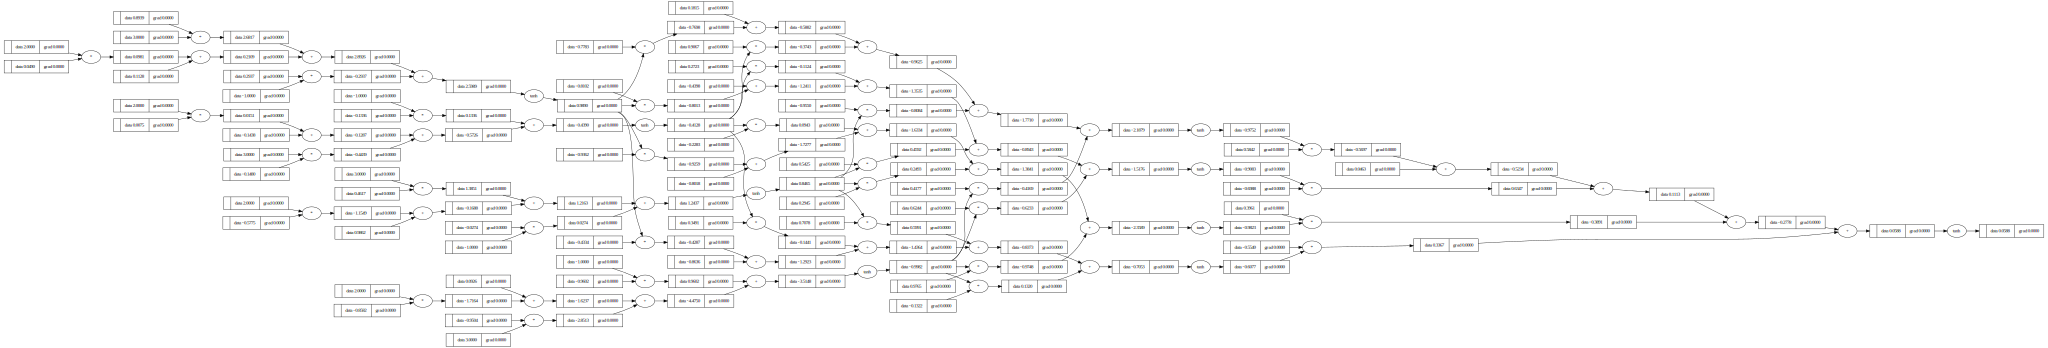

In [41]:
draw_dot(m(x))

In the example below see see 3x4 input vector. This means that in the beginning the first element [2.0, 3.0, -1.0] is the input to all neurons in the input layer, then [3.0, -1.0, 0.5] is the input, then [0.5, 1.0, 1.0] and [1.0, 1.0, -1.0] at the end. But at any given time all input neurons have the same input.

In [42]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [43]:
ypred = [m(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  

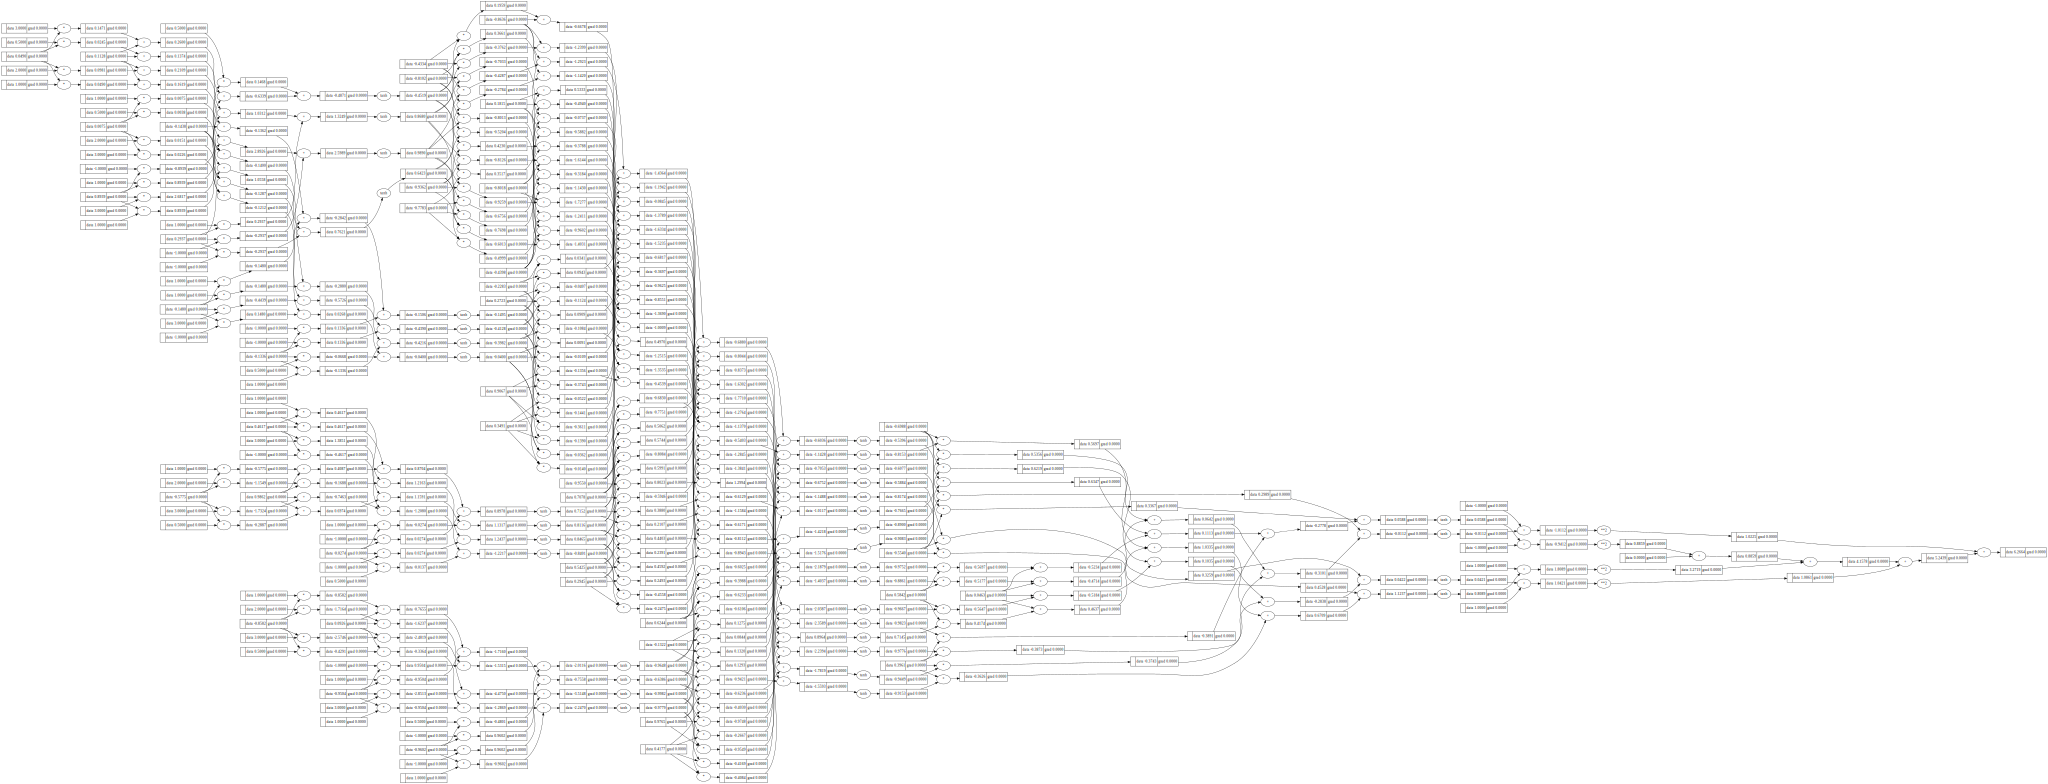

In [44]:
draw_dot(loss)

In [45]:
for k in range(20):
    #forward pass
    ypred = [m(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  

    #backward pass
    for p in m.parameters():
        p.grad = 0.0
    loss.backward()

    #update
    for p in m.parameters():
        p.data -= 0.05 * p.grad   

    print(k, loss.data)


0 6.266410526110076
1 5.836449871507714
2 5.437780332130588
3 4.907692908723736
4 4.361379008894644
5 3.9995888747787305
6 3.708589726184108
7 3.3061105922606497
8 2.7752947229095866
9 2.373667277537894
10 2.0817715425698182
11 1.7734146403250899
12 1.4247982906356929
13 1.0750048587168082
14 0.7817459838406569
15 0.5686307622413042
16 0.4236669878927836
17 0.32574899613719577
18 0.2582016301837875
19 0.21019548631292828


In [46]:
ypred = [m(x) for x in xs]
ypred

[Value (data=0.8244157371110187),
 Value (data=-0.9413915055710611),
 Value (data=-0.7281527186563671),
 Value (data=0.7414155593870326)]